In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

In [36]:
# Load the dataset
file_path = 'data/AirQualityUCI.csv'
df = pd.read_csv(file_path, delimiter=';')
df.columns = df.columns.str.strip(' ;')

# Replace '/' in Date and '.' in Time to ensure proper formatting
df['Date'] = df['Date'].str.replace('/', '-')
df['Time'] = df['Time'].str.replace('.', ':')  # Replace periods with colons in Time

# Convert to datetime and set as index
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df.set_index('datetime', inplace=True)

# Remove rows with NaT (Not a Time) in datetime index due to parsing issues
df = df[~df.index.isna()]

# Ensure the index is sorted
df = df.sort_index()

# Set the frequency of the datetime index to hourly ('H')
df = df.asfreq('h')

# Clean up the CO(GT) column
df['CO(GT)'] = df['CO(GT)'].str.replace(',', '.')
df['CO(GT)'] = pd.to_numeric(df['CO(GT)'], errors='coerce')
df['CO(GT)'] = df['CO(GT)'].ffill().bfill()

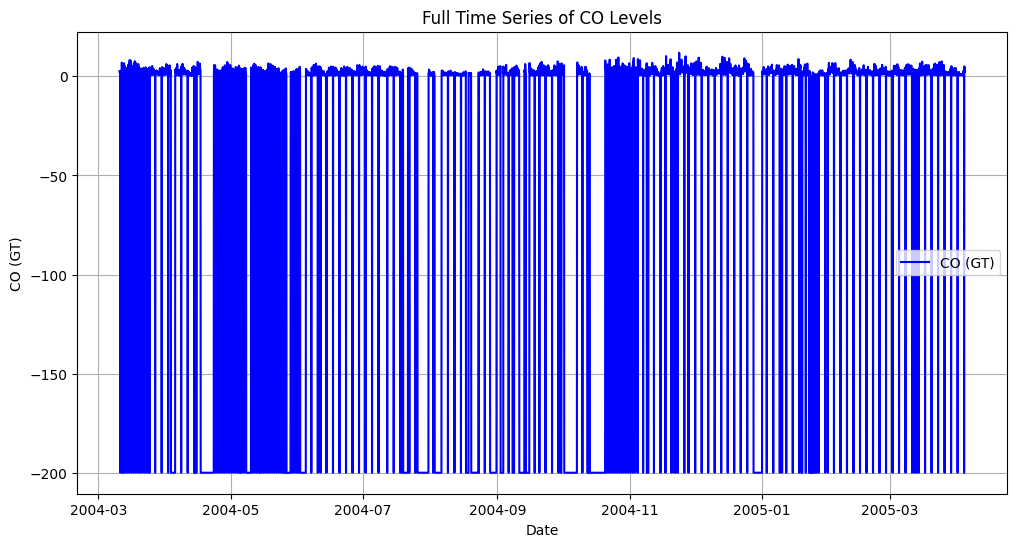

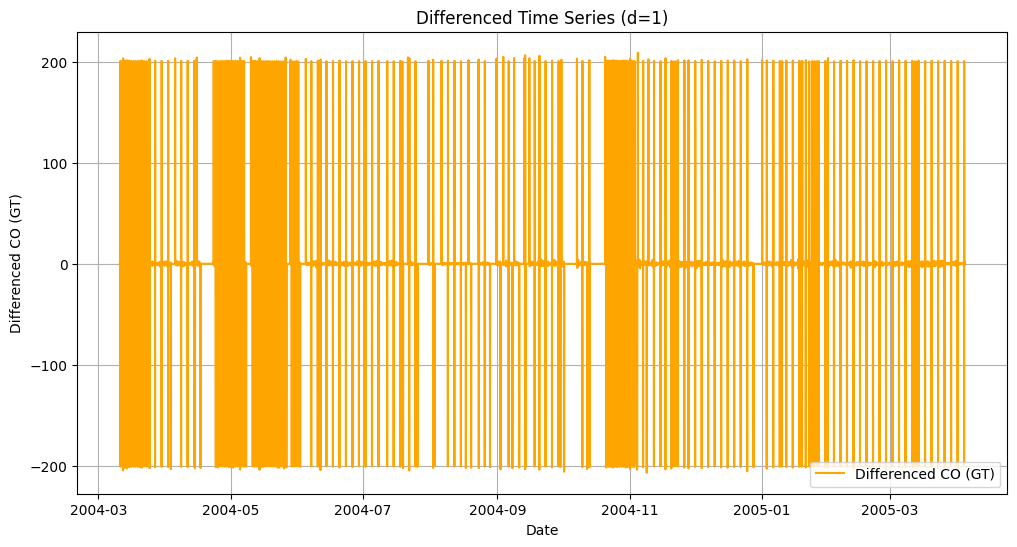

In [37]:
# 1. Constructing the time plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CO(GT)'], label='CO (GT)', color='blue')
plt.title('Full Time Series of CO Levels')
plt.xlabel('Date')
plt.ylabel('CO (GT)')
plt.legend()
plt.grid(True)
plt.show()

# Check stationarity and differencing requirement
# Plotting differenced series (d=1)
plt.figure(figsize=(12, 6))
plt.plot(df['CO(GT)'].diff(), label='Differenced CO (GT)', color='orange')
plt.title('Differenced Time Series (d=1)')
plt.xlabel('Date')
plt.ylabel('Differenced CO (GT)')
plt.legend()
plt.grid(True)
plt.show()

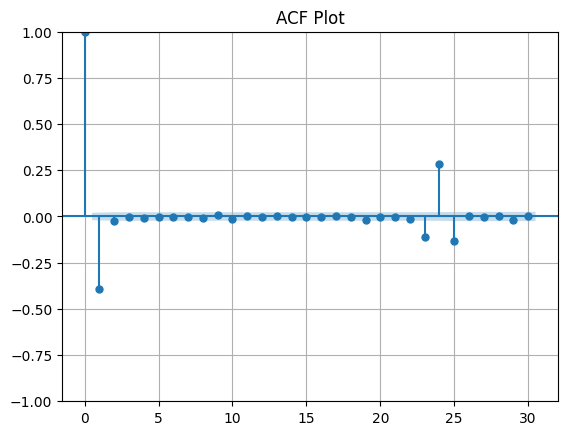

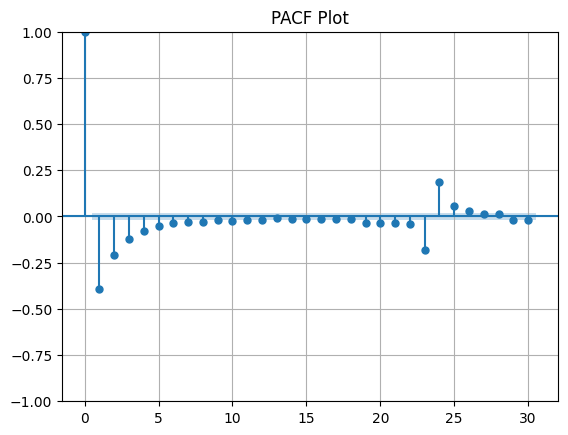

In [38]:
# 2. Autocorrelation and Partial Autocorrelation Plots
# ACF Plot
plot_acf(df['CO(GT)'].diff().dropna(), lags=30)
plt.title('ACF Plot')
plt.grid(True)
plt.show()

# PACF Plot
plot_pacf(df['CO(GT)'].diff().dropna(), lags=30)
plt.title('PACF Plot')
plt.grid(True)
plt.show()

# Initial parameter selection: p=1, d=1, q=1 based on plots
p, d, q = 1, 1, 1

In [39]:
# 3. Fitting the initial ARIMA model
model = ARIMA(df['CO(GT)'], order=(p, d, q))
results = model.fit()
print(results.summary())

# Align fitted values with actual values to calculate MAE and MAPE
fitted_values_aligned = results.fittedvalues.iloc[1:] 
actual_values_aligned = df['CO(GT)'].iloc[1:]

                               SARIMAX Results                                
Dep. Variable:                 CO(GT)   No. Observations:                 9357
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -46735.122
Date:                Wed, 02 Oct 2024   AIC                          93476.244
Time:                        15:07:29   BIC                          93497.676
Sample:                    03-10-2004   HQIC                         93483.523
                         - 04-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1044      0.012      8.394      0.000       0.080       0.129
ma.L1         -0.6178      0.011    -54.394      0.000      -0.640      -0.595
sigma2      1277.1937      5.448    234.442      0.0

In [40]:
# 4. Model Evaluation: Get MAE and MAPE
mae = mean_absolute_error(actual_values_aligned, fitted_values_aligned)
mape = mean_absolute_percentage_error(actual_values_aligned, fitted_values_aligned)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Error (MAE): 10.414749907105831
Mean Absolute Percentage Error (MAPE): 7.753830986219761


Next 5-period Forecast:
2005-04-04 15:00:00    1.838191
2005-04-04 16:00:00    1.800404
2005-04-04 17:00:00    1.796458
2005-04-04 18:00:00    1.796046
2005-04-04 19:00:00    1.796003
Freq: h, Name: predicted_mean, dtype: float64


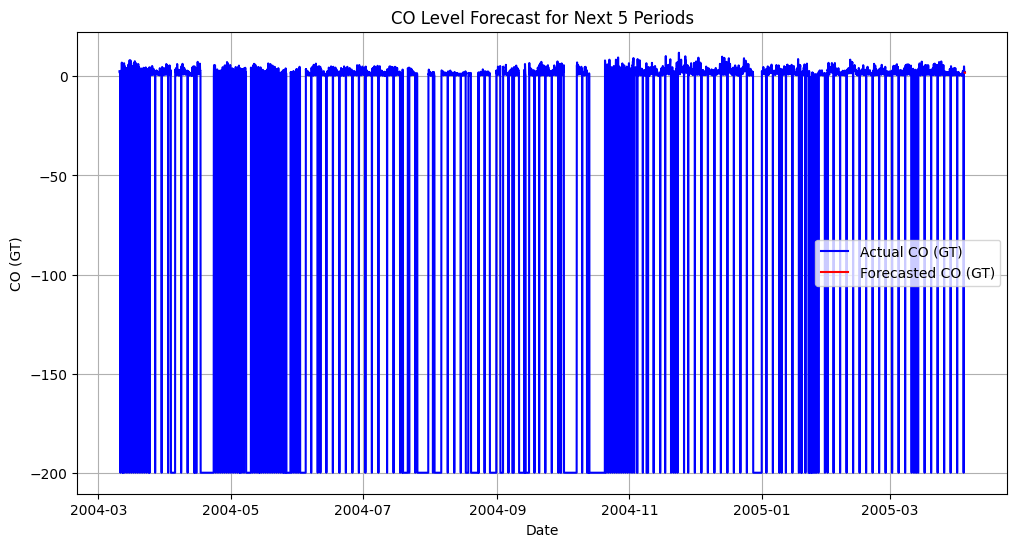

In [41]:
# 5. Forecasting the next five periods
forecast = results.forecast(steps=5)
print("Next 5-period Forecast:")
print(forecast)

# Plotting the forecast vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CO(GT)'], label='Actual CO (GT)', color='blue')
plt.plot(forecast.index, forecast, label='Forecasted CO (GT)', color='red')
plt.title('CO Level Forecast for Next 5 Periods')
plt.xlabel('Date')
plt.ylabel('CO (GT)')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# 6. Parameter Tuning: Fit another ARIMA model with different parameters (p=2, d=1, q=1)
p2, d2, q2 = 2, 1, 1
model2 = ARIMA(df['CO(GT)'], order=(p2, d2, q2))
results2 = model2.fit()
print(results2.summary())

# Aligning fitted values with actual values for Model 2
fitted_values_aligned2 = results2.fittedvalues.iloc[1:] 
actual_values_aligned2 = df['CO(GT)'].iloc[1:] 

# Comparing the models based on MAE and MAPE
mae2 = mean_absolute_error(actual_values_aligned2, fitted_values_aligned2)
mape2 = mean_absolute_percentage_error(actual_values_aligned2, fitted_values_aligned2)

print(f"Model 1 - MAE: {mae}, MAPE: {mape}")
print(f"Model 2 - MAE: {mae2}, MAPE: {mape2}")

                               SARIMAX Results                                
Dep. Variable:                 CO(GT)   No. Observations:                 9357
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -46730.644
Date:                Wed, 02 Oct 2024   AIC                          93469.289
Time:                        15:07:31   BIC                          93497.864
Sample:                    03-10-2004   HQIC                         93478.993
                         - 04-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1766      0.022      8.148      0.000       0.134       0.219
ar.L2          0.0576      0.014      4.014      0.000       0.029       0.086
ma.L1         -0.6915      0.021    -32.223      0.0

In [43]:
# 7. Walk-Forward Validation
# Split the dataset into train and test sets (70% train, 30% test)
train_size = int(len(df) * 0.7)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit the initial ARIMA model on the training data
# Fit once on the training set
initial_model = ARIMA(train['CO(GT)'], order=(p, d, q))
model_fit = initial_model.fit()

# Perform walk-forward validation
history = list(train['CO(GT)'])  # Initialize history with training data
predictions = []

In [44]:
# Iterate over the test set, but limit to first 50 observations to reduce execution time for debugging
for t in range(min(len(test), 50)):  # Use only first 50 samples for testing purposes
    # Forecast the next value (one-step ahead forecast)
    forecast = model_fit.forecast(steps=1)
    yhat = forecast[0]  # Use standard array indexing to access the first element
    predictions.append(yhat)
    
    # Print statement to debug each step
    print(f"Predicted: {yhat}, Expected: {test['CO(GT)'].iloc[t]}")
    
    # Update the history with the new observed value from the test set
    obs = test['CO(GT)'].iloc[t]  # Use iloc for positional indexing in the test set
    history.append(obs)
    
    # Refit the model with the updated history less frequently
    # Instead of fitting in every loop iteration, let's fit every 10 iterations for faster execution
    if (t + 1) % 10 == 0:  # Fit every 10 steps
        model_fit = ARIMA(history, order=(p, d, q)).fit()

/var/folders/lg/zjtzqdq15v77l_2rk_z7jhwh0000gn/T/ipykernel_10422/1100395748.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = forecast[0]  # Use standard array indexing to access the first element


Predicted: 2.2664275222190233, Expected: 1.2
Predicted: 2.2664275222190233, Expected: 1.4
Predicted: 2.2664275222190233, Expected: 1.9
Predicted: 2.2664275222190233, Expected: 2.6
Predicted: 2.2664275222190233, Expected: 2.4
Predicted: 2.2664275222190233, Expected: 3.5
Predicted: 2.2664275222190233, Expected: 3.5
Predicted: 2.2664275222190233, Expected: 2.2
Predicted: 2.2664275222190233, Expected: 2.3
Predicted: 2.2664275222190233, Expected: 1.9
Predicted: 2.222071335033965, Expected: 1.0
Predicted: 2.222071335033965, Expected: 0.8
Predicted: 2.222071335033965, Expected: 0.5
Predicted: 2.222071335033965, Expected: 0.4
Predicted: 2.222071335033965, Expected: 0.4
Predicted: 2.222071335033965, Expected: 0.4
Predicted: 2.222071335033965, Expected: 0.6
Predicted: 2.222071335033965, Expected: 1.9
Predicted: 2.222071335033965, Expected: 2.0
Predicted: 2.222071335033965, Expected: 1.4
Predicted: 1.445766242772424, Expected: 1.4
Predicted: 1.445766242772424, Expected: 1.5
Predicted: 1.445766242

In [45]:
# Convert predictions to a pandas Series to match test index
predictions_series = pd.Series(predictions, index=test.index[:len(predictions)])

# Evaluate predictions using MAE and MAPE for walk-forward validation
walk_forward_mae = mean_absolute_error(test['CO(GT)'].iloc[:len(predictions)], predictions_series)
walk_forward_mape = mean_absolute_percentage_error(test['CO(GT)'].iloc[:len(predictions)], predictions_series)

print(f"Walk-Forward Validation MAE: {walk_forward_mae}")
print(f"Walk-Forward Validation MAPE: {walk_forward_mape}")

Walk-Forward Validation MAE: 10.073143917893935
Walk-Forward Validation MAPE: 4.859225213587577


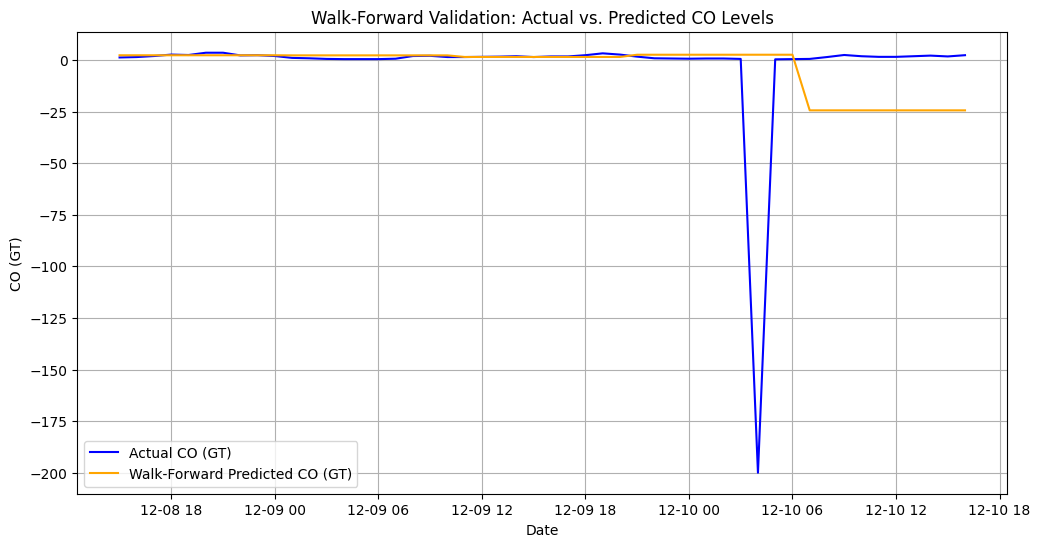

In [46]:
# Plot actual vs. predicted values from walk-forward validation
plt.figure(figsize=(12, 6))
plt.plot(test.index[:len(predictions)], test['CO(GT)'].iloc[:len(predictions)], label='Actual CO (GT)', color='blue')
plt.plot(predictions_series.index, predictions_series, label='Walk-Forward Predicted CO (GT)', color='orange')
plt.title('Walk-Forward Validation: Actual vs. Predicted CO Levels')
plt.xlabel('Date')
plt.ylabel('CO (GT)')
plt.legend()
plt.grid(True)
plt.show()